In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tif

In [3]:
from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import Sample
from sladsnet.code.sampling import run_sampling


###  Step 1: Change the ERD model path and c value as desired. The current script uses the training image 93. The optimal c value for this training model is 16.

Note: I am using pathlib for the paths, but strings should work just fine.

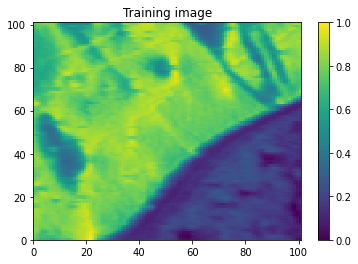

In [4]:

base_path = Path.cwd().parent
train_path = base_path / 'ResultsAndData/TrainingData/93/'
training_img_path = list((train_path / 'Images').glob('*.tif'))[0]
train_img = tif.imread(training_img_path)

plt.pcolormesh(train_img)
plt.colorbar()
plt.title('Training image')
plt.show()

In [5]:
C_VALUE = 16

erd_model = SladsSklearnModel(load_path=train_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [6]:
params_erd = ERDInputParams(c_value=C_VALUE)
params_gen = GeneralInputParams()

### Step 2: Set test image path. If we want to save the output to a specific directory, set the output directory, otherwise use none.

Ensure the output directory existsbeforehand. The test image has to be a tif.

In [7]:
test_img_path = base_path / f'ResultsAndData/TestingImages/TestingImageSet_91/norm_log_sum_91_81x81.tif'
output_save_path = None

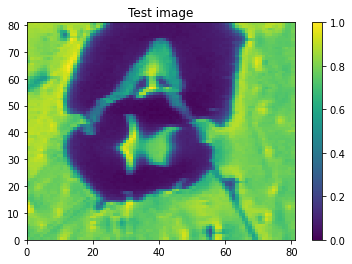

In [8]:
test_img = tif.imread(test_img_path)
plt.pcolormesh(test_img)
plt.colorbar()
plt.title('Test image')
plt.show()

### Step 3: Set the stop ratio (stop_ratio of 0.1 = 10% sampling, 0.4 = 40% sampling, etc.).

### Step 4: Set the frequency at which to store the sampling masks, reconstructions, and predicted ERDs for later access. 
- These are stored in "result", and saved in a pickle file in the output_save_path if output_save_path is specified. If we don't want to store this, set store_results_percentage to None.

- If store_results_frequency = 1 (for example, then the results are stored after 1% of the sample is measured).

In [9]:
stop_ratio = 0.2
store_results_percentage = 1

In [10]:
measurement_interface = TransmissionSimulationMeasurementInterface(image_path=test_img_path)

if store_results_percentage is None or store_results_percentage == 0:
    results = None
else:
    results = Result()

sample_params = SampleParams(image_shape=measurement_interface.image.shape,
                             batch_size=1,
                             stop_ratio=stop_ratio)
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)

### Step 5: Run the sampling 

In [11]:
%%time
run_sampling(sample, results=results, results_frequency_percentage=store_results_percentage, disable_progress_bar=False)

CPU times: user 2min 21s, sys: 14.3 s, total: 2min 36s
Wall time: 9.88 s


### Plot the final results. 

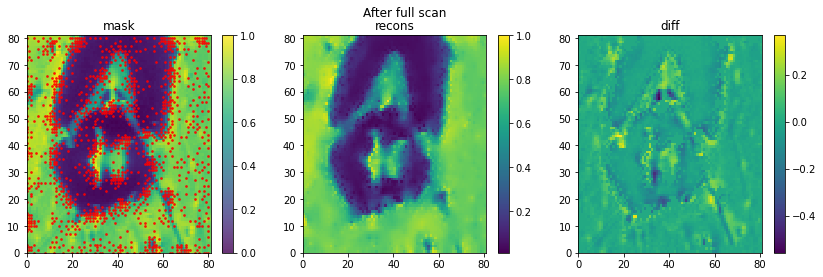

In [12]:
fig, axs = plt.subplots(1, 3, figsize=[14, 4])
plt.subplot(1, 3, 1)

plt.pcolormesh(measurement_interface.image)
plt.scatter(sample.measurement_info.measured_idxs[:, 1],
            sample.measurement_info.measured_idxs[:, 0],
            alpha=0.8, color='red', s=3)
plt.colorbar()
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(sample.recon_image)
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
plt.pcolormesh(measurement_interface.image - sample.recon_image)
plt.colorbar()
plt.title('diff')
plt.suptitle('After full scan')
plt.show()

### After the first 10% measurements

In [13]:
results.size

21

In [14]:
midxs = np.where(results.outputs.masks[10])


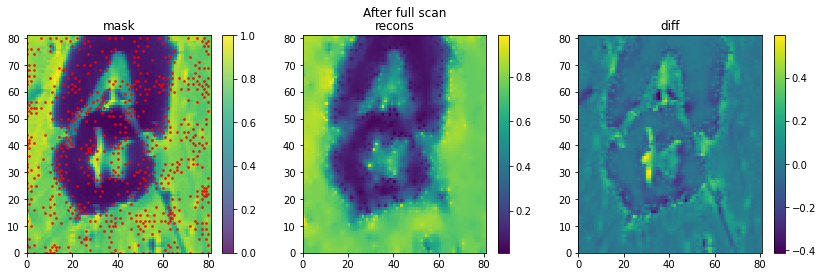

In [15]:
fig, axs = plt.subplots(1, 3, figsize=[14, 4])
plt.subplot(1, 3, 1)

plt.pcolormesh(measurement_interface.image)
plt.scatter(midxs[0],
            midxs[1],
            alpha=0.8, color='red', s=3)
plt.colorbar()
plt.title('mask')
plt.subplot(1, 3, 2)
plt.pcolormesh(results.outputs.recons[10])
plt.colorbar()
plt.title('recons')
plt.subplot(1, 3, 3)
plt.pcolormesh(measurement_interface.image - results.outputs.recons[10])
plt.colorbar()
plt.title('diff')
plt.suptitle('After full scan')
plt.show()